In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from sklearn.datasets import load_boston
from torch import nn
from tqdm.notebook import tqdm

In [2]:
# Скачаем данные 
mnist_train = torchvision.datasets.MNIST(
    "./mnist/", 
    train=True, 
    download=True, 
    transform=torchvision.transforms.ToTensor()
) 
mnist_val = torchvision.datasets.MNIST(
    "./mnist/",
    train=False, 
    download=True,
    transform=torchvision.transforms.ToTensor()
)

# так как это уже унаследованный от Dataset класс, его можно сразу обернуть в даталоадер
train_dataloader = torch.utils.data.DataLoader(
    mnist_train, 
    batch_size=4, 
    shuffle=True, 
    num_workers=1
) 

val_dataloader = torch.utils.data.DataLoader(
    mnist_val, 
    batch_size=4, 
    shuffle=True, 
    num_workers=1
)

100%|██████████| 9912422/9912422 [00:05<00:00, 1807026.64it/s]


Extracting ./mnist/MNIST\raw\train-images-idx3-ubyte.gz to ./mnist/MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]


Extracting ./mnist/MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2305324.03it/s]


Extracting ./mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist/MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist/MNIST\raw



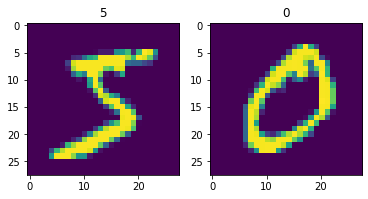

In [3]:
# Посмотрим с чем работаем
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(mnist_train[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(mnist_train[i][1]))
plt.show()

In [4]:
model = nn.Sequential(
    nn.Flatten(),             # превращаем картинку 28х28 в вектор размером 784
    nn.Linear(28 * 28, 128),  # линейный слой, преобразующий вектор размера 784 в вектор размера 128
    nn.ReLU(),                # нелинейность
    nn.Linear(128, 10),       # линейный слой, преобразующий вектор размера 128 в вектор размера 10
)

# создаем оптимизатор, который будет обновлять веса модели
optimizer = torch.optim.SGD(model.parameters(), lr=0.05) 

Параметры выглядят следующем образом:

In [5]:
[x for x in model.named_parameters()] 

[('1.weight',
  Parameter containing:
  tensor([[ 0.0265,  0.0292, -0.0209,  ...,  0.0295,  0.0245,  0.0309],
          [ 0.0139, -0.0144, -0.0306,  ...,  0.0193,  0.0201, -0.0116],
          [-0.0220,  0.0235,  0.0298,  ...,  0.0227, -0.0287, -0.0120],
          ...,
          [ 0.0143, -0.0029,  0.0271,  ..., -0.0348,  0.0111, -0.0291],
          [ 0.0267,  0.0087,  0.0030,  ..., -0.0221, -0.0210, -0.0062],
          [-0.0309, -0.0119,  0.0087,  ..., -0.0146,  0.0144, -0.0110]],
         requires_grad=True)),
 ('1.bias',
  Parameter containing:
  tensor([ 0.0354,  0.0328, -0.0137, -0.0285,  0.0280,  0.0169, -0.0243, -0.0066,
           0.0086, -0.0216,  0.0301,  0.0040, -0.0323,  0.0255, -0.0107, -0.0074,
          -0.0128,  0.0117, -0.0033,  0.0275, -0.0228,  0.0240,  0.0280, -0.0104,
          -0.0049,  0.0026,  0.0345,  0.0224, -0.0113, -0.0046, -0.0032,  0.0064,
          -0.0259, -0.0167, -0.0300, -0.0294, -0.0001,  0.0021, -0.0208, -0.0233,
           0.0295, -0.0035, -0.0264, 

Для красивых метрик

In [ ]:
# !pip install wandb --upgrade --quiet
import wandb

# логинимся в своего пользователя (предварительно нужно ввести ключ из настроек с wandb.ai через консоль)
wandb.login()
# инициализируем проект
wandb.init(project="pytorch-demo")
# сохраняем параметры сетки в wandb + просим следить за градиентами сетки
wandb.watch(model);

In [6]:
# всего у нас будет 5 эпох (5 раз подряд пройдемся по всем батчам из трейна)
for epoch in range(5):
    for x_train, y_train in tqdm(train_dataloader):    # берем батч из трейн лоадера
        y_pred = model(x_train)                        # делаем предсказания
        loss = F.cross_entropy(y_pred, y_train)        # считаем лосс
        loss.backward()                                # считаем градиенты обратным проходом
        optimizer.step()                               # обновляем параметры сети
        optimizer.zero_grad()                          # обнуляем посчитанные градиенты параметров
    
    if epoch % 2 == 0:
        val_loss = []                                  # сюда будем складывать **средний по бачу** лосс
        val_accuracy = []
        with torch.no_grad():                          # на валидации запрещаем фреймворку считать градиенты по параметрам
            for x_val, y_val in tqdm(val_dataloader):  # берем батч из вал лоадера
                y_pred = model(x_val)                  # делаем предсказания
                loss = F.cross_entropy(y_pred, y_val)  # считаем лосс
                val_loss.append(loss.numpy())          # добавляем в массив 
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
          
        # скидываем метрики на wandb и автоматом смотрим на графики
        #wandb.log({"mean val loss": np.mean(val_loss),
        #           "mean val accuracy": np.mean(val_accuracy)})
        
        # печатаем метрики
        print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 0, loss: 0.11758233606815338, accuracy: 0.9646


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 0.08408485352993011, accuracy: 0.9736


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.080023854970932, accuracy: 0.9772
